# Caracterização dos dados sobre itens e lotes

Trabalho que busca caracterizar os dados obtidos sobre itens e lotes. Busca-se entender como os custos por licitação se relacionam com os valores unitários dos itens e suas quantidades, para então entender a qualidade dos dados obtidos e a viabilidade dos valores das licitações como pesos para a construção de alarmes

In [35]:
# Library imports
import time
import gc
import pandas as pd
import numpy as np
import dask.dataframe as dd
%matplotlib inline
import matplotlib.pyplot as plt
from dask.multiprocessing import get
from pandas_profiling import ProfileReport

## Carregamento de dados

In [2]:
input_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/participacoes-itens.csv'

desired_cols = [
    'id_licitacao', #0
    'id_item_licitacao', #1
    #'id_orgao', #2
    #'cod_orgao', #3
    #'nome_orgao', #4
    #'cod_nome_tipo_orgao', #5
    #'nome_tipo_orgao', #6
    #'nome_regiaoplanejamento', #7
    #'ano_exercicio', #8
    #'mes_licitacao', #9
    'num_lote', #10
    #'nome_lote', #11
    'num_item', #12
    #'nome_item', #13
    'vlr_unitario', #14
    'num_quant_item', #15
    'vlr_perc_desconto', #16
    #'vlr_perc_taxa_adm', #17
    'vlr_global', #18
    #'dsc_ind_desonera_folha', #19
    # 'num_cpf_cnpj_licitante', #20
    #'nome_licitante', #21
    #'cod_tipo_pessoa_licitante', #22
    #'cod_ibge_municipio', #23
    #'num_cpf_cnpj_municipio', #24
    'nome_cidade', #25
    #'nome_microrregiao', #26
    #'nome_mesorregiao', #27
    #'nome_regiao_imediata', #28
    #'nome_regiao_intermediaria' #29
    #'sigla_uf', #30
    #'longitude', #31
    #'latitude' #32
]

start_time = time.time()
df = pd.read_csv(input_path, sep=';', usecols=desired_cols)
print("--- %s seconds ---" % (time.time() - start_time))

df

/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1,10,12,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


--- 87.10656785964966 seconds ---


,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade
0,111889,3913090,NaN,1,10710,1,0,0,IRAI DE MINAS
1,111846,3911900,NaN,1,40000,1,0,0,IRAI DE MINAS
2,111846,3911901,NaN,2,39265,1,0,0,IRAI DE MINAS
3,111852,3911940,NaN,36,21,25,0,0,IRAI DE MINAS
4,111852,3911952,NaN,49,1.4,450,0,0,IRAI DE MINAS
...,...,...,...,...,...,...,...,...,...
29866932,582068,19038527,NaN,1,30885,1,0,0,SANTO ANTONIO DO AMPARO
29866933,582067,19038526,NaN,1,38911,1,0,0,SANTO ANTONIO DO AMPARO
29866934,582068,19038527,NaN,1,32309,1,0,0,SANTO ANTONIO DO AMPARO
29866935,582068,19038527,NaN,1,33790,1,0,0,SANTO ANTONIO DO AMPARO


## Limpeza dos dados
* Valores não numéricos são convertidos para numéricos
* Valores inválidos são considerados como 0.

In [3]:
df.vlr_global = pd.to_numeric(df.vlr_global, errors='coerce')
df.vlr_global = df.vlr_global.replace('NaN', 0)

In [4]:
df.vlr_unitario = pd.to_numeric(df.vlr_unitario, errors='coerce')
df.vlr_unitario = df.vlr_unitario.replace('NaN', 0)

In [5]:
df.vlr_perc_desconto = pd.to_numeric(df.vlr_perc_desconto, errors='coerce')
df.vlr_perc_desconto = df.vlr_perc_desconto.replace('NaN', 0)

In [6]:
df.num_quant_item = pd.to_numeric(df.num_quant_item, errors='coerce')
df.num_quant_item = df.num_quant_item.replace('NaN', 0)

## Análise básica de utilidade dos campos
Muitos dos campos têm valores incoerentes ou nulos, que são de pouca serventia. Analisando os dados, nota-se que para todos os casos, temos sempre um OU `vlr_global` OU `vlr_unitario` e `num_itens`, mas nunca os dois. Assim, para cada caso o valor efetivo do item deve ser extrapolado a partir desses outros fatores.

No caso em que temos `vlr_global`, usamos ele. Quando não temos, usamos `vlr_unitario` * `num_itens` * (1-`vlr_perc_desconto`/100)

Por isso, calculamos um `vlr_global_efetivo`, que observa qual dos dois está disponível e o considera como o valor real.

Ao analisar os itens que excedem o valor de 1 bilhão, todas elas têm o valor `vlr_global` nulo e, portanto, têm como problema um grande número de itens associado a itens com valor muito alto. Foram encontradas 189 entradas

Ao agrupar os itens bilionários por `id_item_licitacao` e verificar quantos grupos temos 159, o que sugere que há mais de uma linha para alguns desses itens. Assim, há mais de um CNPJ licitante e, portanto, há problemas na base de dados de interesse. Mais precisamente, 20 das 159 licitações bilionárias são de nosso interesse.

In [58]:
df.vlr_perc_desconto.value_counts() # Tem valores razoáveis

0.00     29697739
10.00        6627
5.00         5389
15.00        5000
20.00        4572
           ...   
7.51            1
18.56           1
25.88           1
36.48           1
57.07           1
Name: vlr_perc_desconto, Length: 3743, dtype: int64

In [60]:
df.vlr_global.value_counts() # Quase tudo zero

0.00          29791335
1631482.52         333
567432.96          224
404392.51          132
442026.72          130
                ...   
7946.50              1
191.87               1
6570.31              1
2585.05              1
6805.33              1
Name: vlr_global, Length: 55900, dtype: int64

In [61]:
df.num_lote.value_counts() # Quase tudo zero

1.0       1138198
2.0        515767
3.0        433222
4.0        379588
5.0        323433
           ...   
8568.0          1
8567.0          1
8566.0          1
8565.0          1
7489.0          1
Name: num_lote, Length: 7026, dtype: int64

In [57]:
def get_vlr_global_efetivo(row):
    quant = row.num_quant_item
    unit_value = row.vlr_unitario
    discount = row.vlr_perc_desconto
    
    if unit_value > 0: return quant * unit_value * (1 - discount/100)
    
    return row.vlr_global
    
start_time = time.time()

ddf = dd.from_pandas(df, npartitions=30)
vlr_global_efetivo = ddf.map_partitions(lambda df: df.apply((lambda row: get_vlr_global_efetivo(row)), axis=1)).compute(scheduler='processes')
df['vlr_global_efetivo'] = vlr_global_efetivo

print("--- %s seconds ---" % (time.time() - start_time))

df

--- 163.4968342781067 seconds ---


,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,vlr_global_efetivo
0,111889,3913090,NaN,1,10710.0,1.0,0.0,0.0,IRAI DE MINAS,10710.0
1,111846,3911900,NaN,1,40000.0,1.0,0.0,0.0,IRAI DE MINAS,40000.0
2,111846,3911901,NaN,2,39265.0,1.0,0.0,0.0,IRAI DE MINAS,39265.0
3,111852,3911940,NaN,36,21.0,25.0,0.0,0.0,IRAI DE MINAS,525.0
4,111852,3911952,NaN,49,1.4,450.0,0.0,0.0,IRAI DE MINAS,630.0
...,...,...,...,...,...,...,...,...,...,...
29866932,582068,19038527,NaN,1,30885.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,30885.0
29866933,582067,19038526,NaN,1,38911.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,38911.0
29866934,582068,19038527,NaN,1,32309.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,32309.0
29866935,582068,19038527,NaN,1,33790.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,33790.0


In [77]:
bilhao = 1000000000

df.loc[df.vlr_global_efetivo > bilhao]

df.loc[(df.vlr_global_efetivo > bilhao) & (df.vlr_global > 0)]

,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,vlr_global_efetivo
298028,571580,18703572,113.0,1,47700.00,45000.00,0.0,0.0,ITUIUTABA,2.146500e+09
298752,595399,19455042,242.0,46,61676.77,60000.00,0.0,0.0,ITUIUTABA,3.700606e+09
326662,821904,26672339,342.0,33,42750.00,60000.00,0.0,0.0,ITUIUTABA,2.565000e+09
326664,821904,26672319,342.0,13,60214.23,20000.00,0.0,0.0,ITUIUTABA,1.204285e+09
326704,821904,26672339,342.0,33,60214.23,60000.00,0.0,0.0,ITUIUTABA,3.612854e+09
...,...,...,...,...,...,...,...,...,...,...
27314772,367920,11892602,NaN,378.0,597243.55,5000.00,61.0,0.0,PEQUERI,1.164625e+09
27314844,367920,11892603,NaN,379.0,597243.55,5000.00,47.0,0.0,PEQUERI,1.582695e+09
27314940,367920,11892587,NaN,363.0,597243.55,2000.00,13.5,0.0,PEQUERI,1.033231e+09
27314941,367920,11892230,NaN,4.0,597243.55,4000.00,10.0,0.0,PEQUERI,2.150077e+09


In [73]:
df.loc[df.vlr_global_efetivo > bilhao].groupby(['id_item_licitacao']).nome_cidade.agg([len])

,len
id_item_licitacao,
385807,1
523866,1
523871,1
523873,1
1209730,1
...,...
26573362,1
26573363,1
26672319,1


In [74]:
df.loc[df.vlr_global_efetivo > bilhao].groupby(['id_item_licitacao']).nome_cidade.agg([len]).value_counts()

len
1      132
2       10
3        8
4        1
6        1
dtype: int64

## Análise dos itens com mais de um participante

Nos interessamos agora apenas pelos itens que tiveram mais do que um participante, uma vez que o trabalho do grupo é baseado em vínculos entre licitantes. Utilizamos o número de linhas em que um item aparece para determinar quantos CNPJs participaram daquele item. 

Contudo, isso nnos dá, de cara, algumas anomalias. Percebe-se que mesmo eliminando duplicatas (só precisamos de uma linha por item, já com as participações contadas), alguns itens têm mais do que uma linha, apresentando valores de `vlr_unitario` distintos, mesmo tendo mesmo `id_item_licitacao` e `num_item`.

&nbsp;

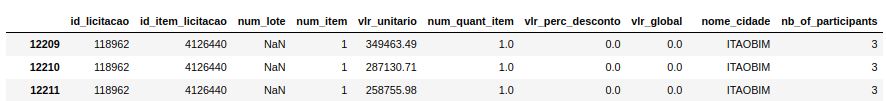
&nbsp;

&nbsp;

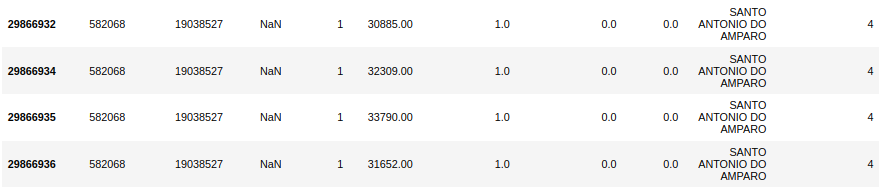

&nbsp;

Isso leva a crer que o valor do item cadastrado para diferentes CNPJs licitantes é, assim, distinto, como em um leilão. Contudo, isso inviabiliza uma análise real dos valores das licitações, a não ser que resolvamos tratar o valor efetivo como a média dos valores que aparecem nas diferentes linhas.

Ao filtrar os itens bilionários, encontramos, dessa vez, 73 linhas. Contudo, há, novamente, itens com mais de uma linha. Há, portanto, CNPJs que fizeram proposições milionárias.

Em seguida fazemos a análise com a média do valor de cada item, abstraindo as ofertas dos diferentes CNPJs.

Criamos assim um dataframe small_df, que contém, para cada item, o seu valor médio e as informações básicas sobre ele. Usando isso, constata-se que apenas 30 itens dos 5 milhões de itens individuais são bilionários. Provavelmente, eles deverão ser filtrados ou ter seu valor alterado, mas não parecem comprometer a base de dados como um todo, desde que tomemos consciência deles.


In [7]:
df['nb_of_participants'] = df.groupby('id_item_licitacao')['id_item_licitacao'].transform('count')
df

,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,nb_of_participants
0,111889,3913090,NaN,1,10710.0,1.0,0.0,0.0,IRAI DE MINAS,1
1,111846,3911900,NaN,1,40000.0,1.0,0.0,0.0,IRAI DE MINAS,1
2,111846,3911901,NaN,2,39265.0,1.0,0.0,0.0,IRAI DE MINAS,1
3,111852,3911940,NaN,36,21.0,25.0,0.0,0.0,IRAI DE MINAS,1
4,111852,3911952,NaN,49,1.4,450.0,0.0,0.0,IRAI DE MINAS,1
...,...,...,...,...,...,...,...,...,...,...
29866932,582068,19038527,NaN,1,30885.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4
29866933,582067,19038526,NaN,1,38911.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,1
29866934,582068,19038527,NaN,1,32309.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4
29866935,582068,19038527,NaN,1,33790.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4


In [8]:
df = df[df.nb_of_participants > 1]
df

,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,nb_of_participants
12209,118962,4126440,NaN,1,349463.49,1.0,0.0,0.0,ITAOBIM,3
12210,118962,4126440,NaN,1,287130.71,1.0,0.0,0.0,ITAOBIM,3
12211,118962,4126440,NaN,1,258755.98,1.0,0.0,0.0,ITAOBIM,3
12212,118965,4126451,1,1,48500.00,1.0,0.0,0.0,ITAOBIM,3
12213,118965,4126451,1,1,48400.00,1.0,0.0,0.0,ITAOBIM,3
...,...,...,...,...,...,...,...,...,...,...
29866931,582057,19038222,NaN,1,25125.95,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,3
29866932,582068,19038527,NaN,1,30885.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4
29866934,582068,19038527,NaN,1,32309.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4
29866935,582068,19038527,NaN,1,33790.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4


In [9]:
# Manter apenas uma entrada por item
df = df.drop_duplicates()
df

,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,nb_of_participants
12209,118962,4126440,NaN,1,349463.49,1.0,0.0,0.0,ITAOBIM,3
12210,118962,4126440,NaN,1,287130.71,1.0,0.0,0.0,ITAOBIM,3
12211,118962,4126440,NaN,1,258755.98,1.0,0.0,0.0,ITAOBIM,3
12212,118965,4126451,1,1,48500.00,1.0,0.0,0.0,ITAOBIM,3
12213,118965,4126451,1,1,48400.00,1.0,0.0,0.0,ITAOBIM,3
...,...,...,...,...,...,...,...,...,...,...
29866931,582057,19038222,NaN,1,25125.95,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,3
29866932,582068,19038527,NaN,1,30885.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4
29866934,582068,19038527,NaN,1,32309.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4
29866935,582068,19038527,NaN,1,33790.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4


In [10]:
def get_vlr_global_efetivo(row):
    quant = row.num_quant_item
    unit_value = row.vlr_unitario
    discount = row.vlr_perc_desconto
    
    if unit_value > 0: return quant * unit_value * (1 - discount/100)
    
    return row.vlr_global
    
start_time = time.time()

ddf = dd.from_pandas(df, npartitions=60)
vlr_global_efetivo = ddf.map_partitions(lambda df: df.apply((lambda row: get_vlr_global_efetivo(row)), axis=1)).compute(scheduler='processes')
df['vlr_global_efetivo'] = vlr_global_efetivo

print("--- %s seconds ---" % (time.time() - start_time))

df

--- 168.00479173660278 seconds ---


/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,nb_of_participants,vlr_global_efetivo
12209,118962,4126440,NaN,1,349463.49,1.0,0.0,0.0,ITAOBIM,3,349463.49
12210,118962,4126440,NaN,1,287130.71,1.0,0.0,0.0,ITAOBIM,3,287130.71
12211,118962,4126440,NaN,1,258755.98,1.0,0.0,0.0,ITAOBIM,3,258755.98
12212,118965,4126451,1,1,48500.00,1.0,0.0,0.0,ITAOBIM,3,48500.00
12213,118965,4126451,1,1,48400.00,1.0,0.0,0.0,ITAOBIM,3,48400.00
...,...,...,...,...,...,...,...,...,...,...,...
29866931,582057,19038222,NaN,1,25125.95,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,3,25125.95
29866932,582068,19038527,NaN,1,30885.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4,30885.00
29866934,582068,19038527,NaN,1,32309.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4,32309.00
29866935,582068,19038527,NaN,1,33790.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4,33790.00


In [11]:
bilhao = 1000000000

df.loc[df.vlr_global_efetivo > bilhao]

,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,nb_of_participants,vlr_global_efetivo
298028,571580,18703572,113,1,47700.00,45000.00,0.0,0.0,ITUIUTABA,2,2.146500e+09
298752,595399,19455042,242,46,61676.77,60000.00,0.0,0.0,ITUIUTABA,2,3.700606e+09
326662,821904,26672339,342,33,42750.00,60000.00,0.0,0.0,ITUIUTABA,3,2.565000e+09
326664,821904,26672319,342,13,60214.23,20000.00,0.0,0.0,ITUIUTABA,3,1.204285e+09
326704,821904,26672339,342,33,60214.23,60000.00,0.0,0.0,ITUIUTABA,3,3.612854e+09
...,...,...,...,...,...,...,...,...,...,...,...
26740607,422991,13528917,NaN,1,60067.61,61040.96,0.0,0.0,MUTUM,3,3.666585e+09
26740608,422991,13528917,NaN,1,58090.66,61040.96,0.0,0.0,MUTUM,3,3.545910e+09
26885082,818298,26573362,3,3,1731660.20,1731821.22,0.0,0.0,MONTES CLAROS,2,2.998926e+12
26885146,818298,26573363,4,4,1731660.20,1731821.22,0.0,0.0,MONTES CLAROS,2,2.998926e+12


In [12]:
df['avg_vlr'] = df.groupby('id_item_licitacao')['vlr_global_efetivo'].transform(np.mean)
df

/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade,nb_of_participants,vlr_global_efetivo,avg_vlr
12209,118962,4126440,NaN,1,349463.49,1.0,0.0,0.0,ITAOBIM,3,349463.49,298450.060000
12210,118962,4126440,NaN,1,287130.71,1.0,0.0,0.0,ITAOBIM,3,287130.71,298450.060000
12211,118962,4126440,NaN,1,258755.98,1.0,0.0,0.0,ITAOBIM,3,258755.98,298450.060000
12212,118965,4126451,1,1,48500.00,1.0,0.0,0.0,ITAOBIM,3,48500.00,47266.666667
12213,118965,4126451,1,1,48400.00,1.0,0.0,0.0,ITAOBIM,3,48400.00,47266.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
29866931,582057,19038222,NaN,1,25125.95,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,3,25125.95,25346.746667
29866932,582068,19038527,NaN,1,30885.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4,30885.00,32159.000000
29866934,582068,19038527,NaN,1,32309.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4,32309.00,32159.000000
29866935,582068,19038527,NaN,1,33790.00,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO,4,33790.00,32159.000000


In [13]:
small_df = df.drop(columns=['vlr_unitario', 'num_quant_item', 'vlr_perc_desconto','vlr_global', 'vlr_global_efetivo', 'num_lote', 'num_item'])
small_df = small_df.drop_duplicates()
small_df

,id_licitacao,id_item_licitacao,nome_cidade,nb_of_participants,avg_vlr
12209,118962,4126440,ITAOBIM,3,298450.060000
12212,118965,4126451,ITAOBIM,3,47266.666667
12215,118936,4125565,ITAOBIM,2,1495.000000
12216,118936,4125572,ITAOBIM,2,26175.000000
12217,118936,4125578,ITAOBIM,2,1340.000000
...,...,...,...,...,...
29866903,582041,19038067,SANTO ANTONIO DO AMPARO,2,83.000000
29866923,582042,19038065,SANTO ANTONIO DO AMPARO,3,62800.000000
29866926,582057,19038222,SANTO ANTONIO DO AMPARO,3,25346.746667
29866927,582056,19038221,SANTO ANTONIO DO AMPARO,3,31200.000000


In [14]:
output_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/licitacoes-itens-reduzido.csv'
small_df.to_csv(output_path, sep=';', index=False)

In [40]:
profile = ProfileReport(small_df, title="Perfil de itens")

In [41]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

MemoryError: 

In [37]:
bilhao = 1000000000

small_df.loc[small_df.avg_vlr > bilhao]

,id_licitacao,id_item_licitacao,num_lote,num_item,nome_cidade,nb_of_participants,avg_vlr
298028,571580,18703572,113,1,ITUIUTABA,2,1.073272e+09
298686,595399,19455042,242,46,ITUIUTABA,2,1.850304e+09
326662,821904,26672339,342,33,ITUIUTABA,3,2.059286e+09
393621,245458,8301951,8,8,SAO FRANCISCO DE PAULA,3,2.146704e+09
393629,245458,8301946,3,3,SAO FRANCISCO DE PAULA,3,2.019878e+09
393635,245458,8301948,5,5,SAO FRANCISCO DE PAULA,2,1.955034e+09
1516051,613021,20065442,NaN,29,CONTAGEM,21,1.111369e+09
1516054,613021,20065418,NaN,3,CONTAGEM,21,1.251450e+09
1536706,472568,15227454,NaN,28,CONTAGEM,40,7.504829e+09
8185305,637666,20883460,5,18,JOAO MONLEVADE,21,4.571485e+09


## Caracterização por vlr_global

* Há 75595 linhas com valor global, sendo que para um mesmo item há valores globais diferentes. Dessa forma, para cada item computamos o valor mínimo. Pra as linhas em que o item é -1, mantivemos o valor global como valor mínimo, interpretando que não há itens diversos na licitação, mas sim um item único
* Há 44151 linhas correspondentes a itens com mais de um CNPJ licitante, correspondendo a 13722 itens distintos (em realidade, são 13832 itens, pois a consulta também agrupou os itens com id_item_licitacao igual a -1. Vai ser melhor tratar de um id composto licitação-item, para considerar os casos em que o id do item é -1, caso em que o id da licitação deve valer.
* Também foi gerado um dataframe que tem somente os itens com múltiplos cnpjs associados, tomando o cuidado de preservar os itens com id -1 como entradas separadas e com valor próprio.
* Há uma seção de exportações para gerar esses dados

### Carregamento de dados

#### Colunas e dtypes

In [5]:
input_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/participacoes-itens.csv'

desired_cols = [
    'id_licitacao', #0
    'id_item_licitacao', #1
    'id_orgao', #2
    'cod_orgao', #3
    'nome_orgao', #4
    'cod_nome_tipo_orgao', #5
    'nome_tipo_orgao', #6
    'nome_regiaoplanejamento', #7
    'ano_exercicio', #8
    'mes_licitacao', #9
    'num_lote', #10
    'nome_lote', #11
    'num_item', #12
    'nome_item', #13
    'vlr_unitario', #14
    'num_quant_item', #15
    'vlr_perc_desconto', #16
    'vlr_perc_taxa_adm', #17
    'vlr_global', #18
    'dsc_ind_desonera_folha', #19
    'num_cpf_cnpj_licitante', #20
    'nome_licitante', #21
    'cod_tipo_pessoa_licitante', #22
    'cod_ibge_municipio', #23
    'num_cpf_cnpj_municipio', #24
    'nome_cidade', #25
    'nome_microrregiao', #26
    'nome_mesorregiao', #27
    'nome_regiao_imediata', #28
    'nome_regiao_intermediaria', #29
    'sigla_uf', #30
    'longitude', #31
    'latitude' #32
]

dtypes = {
    'dsc_ind_desonera_folha': 'object',
    'nome_lote': 'object',
    'num_item': 'object',
    'ano_exercicio': 'object',
    'cod_ibge_municipio': 'object',
    'cod_nome_tipo_orgao': 'object',
    'cod_orgao': 'object',
    'id_item_licitacao': 'object',
    'id_licitacao': 'object',
    'id_orgao': 'object',
    'latitude': 'object',
    'longitude': 'object',
    'mes_licitacao': 'object',
    'num_cpf_cnpj_municipio': 'object',
    'num_lote': 'object',
    'num_quant_item': 'object',
    'vlr_global': 'object',
    'vlr_perc_desconto': 'object',
    'vlr_perc_taxa_adm': 'object',
    'vlr_unitario': 'object',
    'num_cpf_cnpj_licitante': 'object'
}

#### Carregamento

In [6]:
start_time = time.time()
ddf = dd.read_csv(input_path, sep=';', usecols=desired_cols, dtype=dtypes)
print("--- %s seconds ---" % (time.time() - start_time))

ddf.head()

--- 0.04537391662597656 seconds ---


,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,...,cod_ibge_municipio,num_cpf_cnpj_municipio,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude
0,111889,3913090,939,02,CAMARA MUNICIPAL DE IRAI DE MINAS,01,CAMARA MUNICIPAL,ALTO PARANAIBA,2015,3,...,3131604,18158642000189,IRAI DE MINAS,PATROCINIO,TRIANGULO MINEIRO/ALTO PARANAIBA,MONTE CARMELO,UBERLANDIA,MG,-47.4575,-19.0439
1,111846,3911900,938,01,PREFEITURA MUNICIPAL DE IRAI DE MINAS,02,PREFEITURA MUNICIPAL,ALTO PARANAIBA,2014,5,...,3131604,18158642000189,IRAI DE MINAS,PATROCINIO,TRIANGULO MINEIRO/ALTO PARANAIBA,MONTE CARMELO,UBERLANDIA,MG,-47.4575,-19.0439
2,111846,3911901,938,01,PREFEITURA MUNICIPAL DE IRAI DE MINAS,02,PREFEITURA MUNICIPAL,ALTO PARANAIBA,2014,5,...,3131604,18158642000189,IRAI DE MINAS,PATROCINIO,TRIANGULO MINEIRO/ALTO PARANAIBA,MONTE CARMELO,UBERLANDIA,MG,-47.4575,-19.0439
3,111852,3911940,938,01,PREFEITURA MUNICIPAL DE IRAI DE MINAS,02,PREFEITURA MUNICIPAL,ALTO PARANAIBA,2014,5,...,3131604,18158642000189,IRAI DE MINAS,PATROCINIO,TRIANGULO MINEIRO/ALTO PARANAIBA,MONTE CARMELO,UBERLANDIA,MG,-47.4575,-19.0439
4,111852,3911952,938,01,PREFEITURA MUNICIPAL DE IRAI DE MINAS,02,PREFEITURA MUNICIPAL,ALTO PARANAIBA,2014,5,...,3131604,18158642000189,IRAI DE MINAS,PATROCINIO,TRIANGULO MINEIRO/ALTO PARANAIBA,MONTE CARMELO,UBERLANDIA,MG,-47.4575,-19.0439


In [2]:
input_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/participacoes-itens-vlr-global.csv'
df = pd.read_csv(input_path, sep=';')
df

,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
0,811467,-1,1337,2,PREFEITURA DE NEPOMUCENO,2,PREFEITURA MUNICIPAL,SUL,2020,5,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
1,853381,-1,1633,2,PREFEITURA MUNICIPAL DE RAPOSOS,2,PREFEITURA MUNICIPAL,CENTRAL,2021,5,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,310165.00,111
2,853374,-1,1633,2,PREFEITURA MUNICIPAL DE RAPOSOS,2,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,336615.65,111
3,853375,-1,1633,2,PREFEITURA MUNICIPAL DE RAPOSOS,2,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,878494.27,111
4,866611,-1,1963,2,PREFEITURA MUNICIPAL DE SARZEDO,2,PREFEITURA MUNICIPAL,CENTRAL,2021,6,...,SARZEDO,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-44.1210,-20.0591,850080.00,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45271,880522,28827115,1204,2,PREFEITURA MUNICIPAL DE MARIANA,2,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,0.70,1
45272,880522,28827116,1204,2,PREFEITURA MUNICIPAL DE MARIANA,2,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,144.27,1
45273,880522,28827117,1204,2,PREFEITURA MUNICIPAL DE MARIANA,2,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1768.50,1
45274,880522,28827118,1204,2,PREFEITURA MUNICIPAL DE MARIANA,2,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1558.84,1


### Limpeza dos valores

In [7]:
ddf.vlr_global = dd.to_numeric(ddf.vlr_global, errors='coerce')
ddf.vlr_global = ddf.vlr_global.replace('NaN', 0)

In [8]:
ddf.id_item_licitacao = dd.to_numeric(ddf.id_item_licitacao, errors='coerce')
ddf.id_item_licitacao = ddf.id_item_licitacao.replace('NaN', 0)

### Seleção dos vlr_global não nulos e uso de média

In [9]:
ddf_vlr_global = ddf.loc[ddf["vlr_global"] > 0]

In [11]:
df = ddf_vlr_global.compute()
df

,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,...,cod_ibge_municipio,num_cpf_cnpj_municipio,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude
49275,789920,25683403.0,982,02,PREFEITURA MUNICIPAL DE ITAOBIM,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,3,...,3133303,18414573000127,ITAOBIM,PEDRA AZUL,JEQUITINHONHA,TEOFILO OTONI,TEOFILO OTONI,MG,-41.5344,-16.583
49278,789920,25683406.0,982,02,PREFEITURA MUNICIPAL DE ITAOBIM,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,3,...,3133303,18414573000127,ITAOBIM,PEDRA AZUL,JEQUITINHONHA,TEOFILO OTONI,TEOFILO OTONI,MG,-41.5344,-16.583
49279,789920,25683404.0,982,02,PREFEITURA MUNICIPAL DE ITAOBIM,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,3,...,3133303,18414573000127,ITAOBIM,PEDRA AZUL,JEQUITINHONHA,TEOFILO OTONI,TEOFILO OTONI,MG,-41.5344,-16.583
49403,789920,25683404.0,982,02,PREFEITURA MUNICIPAL DE ITAOBIM,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,3,...,3133303,18414573000127,ITAOBIM,PEDRA AZUL,JEQUITINHONHA,TEOFILO OTONI,TEOFILO OTONI,MG,-41.5344,-16.583
49404,789920,25683406.0,982,02,PREFEITURA MUNICIPAL DE ITAOBIM,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,3,...,3133303,18414573000127,ITAOBIM,PEDRA AZUL,JEQUITINHONHA,TEOFILO OTONI,TEOFILO OTONI,MG,-41.5344,-16.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78415,812506,26370155.0,1533,02,PREFEITURA MUNICIPAL DE PINTOPOLIS,02,PREFEITURA MUNICIPAL,NORTE,2020,11,...,3150570,01612481000159,PINTOPOLIS,JANUARIA,NORTE DE MINAS,SAO FRANCISCO,MONTES CLAROS,MG,-45.2472,-16.0494
78416,812506,26370044.0,1533,02,PREFEITURA MUNICIPAL DE PINTOPOLIS,02,PREFEITURA MUNICIPAL,NORTE,2020,11,...,3150570,01612481000159,PINTOPOLIS,JANUARIA,NORTE DE MINAS,SAO FRANCISCO,MONTES CLAROS,MG,-45.2472,-16.0494
78417,812506,26370080.0,1533,02,PREFEITURA MUNICIPAL DE PINTOPOLIS,02,PREFEITURA MUNICIPAL,NORTE,2020,11,...,3150570,01612481000159,PINTOPOLIS,JANUARIA,NORTE DE MINAS,SAO FRANCISCO,MONTES CLAROS,MG,-45.2472,-16.0494
78418,812506,26370113.0,1533,02,PREFEITURA MUNICIPAL DE PINTOPOLIS,02,PREFEITURA MUNICIPAL,NORTE,2020,11,...,3150570,01612481000159,PINTOPOLIS,JANUARIA,NORTE DE MINAS,SAO FRANCISCO,MONTES CLAROS,MG,-45.2472,-16.0494


In [12]:
df = df.sort_values('id_item_licitacao')
df

,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,...,cod_ibge_municipio,num_cpf_cnpj_municipio,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude
23794,811467,-1.0,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,2020,5,...,3144607,18244350000169,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276
83286,853381,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,5,...,3153905,18312132000114,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809
83261,853374,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,3153905,18312132000114,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809
83204,853375,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,3153905,18312132000114,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809
117661,866611,-1.0,1963,02,PREFEITURA MUNICIPAL DE SARZEDO,02,PREFEITURA MUNICIPAL,CENTRAL,2021,6,...,3165537,01612509000158,SARZEDO,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-44.121,-20.0591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60098,880522,28827115.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,3140001,18295303000144,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291
60611,880522,28827116.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,3140001,18295303000144,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291
60405,880522,28827117.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,3140001,18295303000144,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291
60099,880522,28827118.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,3140001,18295303000144,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291


### Todos os itens

In [19]:
df_itens = df.drop(columns=['vlr_global', 'num_cpf_cnpj_licitante'])
itens_sem_id = df_itens[df_itens['id_item_licitacao'] == -1]
itens_com_id = df_itens.groupby('id_item_licitacao', as_index=False).first()
itens_com_id = itens_com_id[itens_com_id['id_item_licitacao'] != -1]
df_itens = itens_sem_id.append(itens_com_id).reset_index()
df_itens

,index,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
0,23794,811467,-1.0,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,2020,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
1,83286,853381,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,310165.00,111
2,83261,853374,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,336615.65,111
3,83204,853375,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,878494.27,111
4,117661,866611,-1.0,1963,02,PREFEITURA MUNICIPAL DE SARZEDO,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,SARZEDO,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-44.121,-20.0591,850080.00,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45271,45161,880522,28827115.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,0.70,1
45272,45162,880522,28827116.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,144.27,1
45273,45163,880522,28827117.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1768.50,1
45274,45164,880522,28827118.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1558.84,1


### Junção de itens e determinação de valor mínimo por item

In [18]:
df['vlr_global_minimo'] = df.groupby('id_item_licitacao')['vlr_global'].transform(np.min)

def vlr_minimo(row):
    if (row['id_item_licitacao'] == -1):
        return row['vlr_global']
    
    return row['vlr_global_minimo']

df['vlr_global_minimo'] = df.apply(lambda row: vlr_minimo(row), axis=1)

df

,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
23794,811467,-1.0,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,2020,5,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
83286,853381,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,5,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,310165.00,111
83261,853374,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,336615.65,111
83204,853375,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,878494.27,111
117661,866611,-1.0,1963,02,PREFEITURA MUNICIPAL DE SARZEDO,02,PREFEITURA MUNICIPAL,CENTRAL,2021,6,...,SARZEDO,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-44.121,-20.0591,850080.00,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60098,880522,28827115.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,0.70,1
60611,880522,28827116.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,144.27,1
60405,880522,28827117.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1768.50,1
60099,880522,28827118.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1558.84,1


### Itens com múltiplos participantes

In [20]:
df['nb_of_participants'] = df.groupby('id_item_licitacao')['id_item_licitacao'].transform('count')
df

,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
23794,811467,-1.0,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,2020,5,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
83286,853381,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,5,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,310165.00,111
83261,853374,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,336615.65,111
83204,853375,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,4,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,878494.27,111
117661,866611,-1.0,1963,02,PREFEITURA MUNICIPAL DE SARZEDO,02,PREFEITURA MUNICIPAL,CENTRAL,2021,6,...,SARZEDO,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-44.121,-20.0591,850080.00,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60098,880522,28827115.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,0.70,1
60611,880522,28827116.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,144.27,1
60405,880522,28827117.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1768.50,1
60099,880522,28827118.0,1204,02,PREFEITURA MUNICIPAL DE MARIANA,02,PREFEITURA MUNICIPAL,CENTRAL,2021,7,...,MARIANA,OURO PRETO,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.3313,-20.3291,1558.84,1


In [21]:
df_multiplos_cnpjs = df[df.nb_of_participants > 1].reset_index()
df_multiplos_cnpjs

,index,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
0,23794,811467,-1.0,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,2020,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
1,83286,853381,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,310165.00,111
2,83261,853374,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,336615.65,111
3,83204,853375,-1.0,1633,02,PREFEITURA MUNICIPAL DE RAPOSOS,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,RAPOSOS,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-43.7832,-19.9809,878494.27,111
4,117661,866611,-1.0,1963,02,PREFEITURA MUNICIPAL DE SARZEDO,02,PREFEITURA MUNICIPAL,CENTRAL,2021,...,SARZEDO,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,BELO HORIZONTE,BELO HORIZONTE,MG,-44.121,-20.0591,850080.00,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44146,41774,880473,28825331.0,339,02,PREFEITURA MUNICIPAL DE CAMPO BELO,02,PREFEITURA MUNICIPAL,CENTRO-OESTE,2021,...,CAMPO BELO,CAMPO BELO,OESTE DE MINAS,CAMPO BELO,VARGINHA,MG,-45.2559,-20.9197,112367.40,2
44147,41711,880473,28825331.0,339,02,PREFEITURA MUNICIPAL DE CAMPO BELO,02,PREFEITURA MUNICIPAL,CENTRO-OESTE,2021,...,CAMPO BELO,CAMPO BELO,OESTE DE MINAS,CAMPO BELO,VARGINHA,MG,-45.2559,-20.9197,112367.40,2
44148,161840,880515,28826221.0,1201,02,PREFEITURA MUNICIPAL DE MARIA DA FE - MG,02,PREFEITURA MUNICIPAL,SUL,2021,...,MARIA DA FE,ITAJUBA,SUL/SUDOESTE DE MINAS,ITAJUBA,POUSO ALEGRE,MG,-45.3135,-22.3225,239900.00,3
44149,161828,880515,28826221.0,1201,02,PREFEITURA MUNICIPAL DE MARIA DA FE - MG,02,PREFEITURA MUNICIPAL,SUL,2021,...,MARIA DA FE,ITAJUBA,SUL/SUDOESTE DE MINAS,ITAJUBA,POUSO ALEGRE,MG,-45.3135,-22.3225,239900.00,3


In [22]:
df_items_multiplos_cnpjs = df_multiplos_cnpjs.drop(columns=['vlr_global', 'num_cpf_cnpj_licitante'])
df_items_multiplos_cnpjs = df_items_multiplos_cnpjs.groupby('id_item_licitacao', as_index=False).first()
df_items_multiplos_cnpjs

,id_item_licitacao,index,id_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
0,-1.0,23794,811467,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,2020,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
1,20913819.0,21682,638419,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,1327.40,3
2,20913820.0,21679,638419,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,20202.07,3
3,20913821.0,21688,638419,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,1130.98,3
4,20913822.0,21684,638419,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,2020,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,717.36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13717,28802672.0,52593,879730,139,02,PREFEITURA MUNICIPAL DE BAEPENDI,02,PREFEITURA MUNICIPAL,SUL,2021,...,BAEPENDI,SAO LOURENCO,SUL/SUDOESTE DE MINAS,CAXAMBU - BAEPENDI,POUSO ALEGRE,MG,-44.8221,-22.0168,659991.55,3
13718,28816008.0,4324,880167,841,02,PREFEITURA MUNICIPAL DE GUARACIABA,02,PREFEITURA MUNICIPAL,MATA,2021,...,GUARACIABA,PONTE NOVA,ZONA DA MATA,PONTE NOVA,JUIZ DE FORA,MG,-43.0207,-20.5552,83404.55,2
13719,28822759.0,152317,880397,388,02,PREFEITURA MUNICIPAL DE CAPUTIRA,02,PREFEITURA MUNICIPAL,MATA,2021,...,CAPUTIRA,MANHUACU,ZONA DA MATA,MANHUACU,JUIZ DE FORA,MG,-42.2523,-20.1765,129078.88,2
13720,28825331.0,41774,880473,339,02,PREFEITURA MUNICIPAL DE CAMPO BELO,02,PREFEITURA MUNICIPAL,CENTRO-OESTE,2021,...,CAMPO BELO,CAMPO BELO,OESTE DE MINAS,CAMPO BELO,VARGINHA,MG,-45.2559,-20.9197,112367.40,2


In [23]:
df_items_multiplos_cnpjs_corrigido = df_multiplos_cnpjs.drop(columns=['vlr_global', 'num_cpf_cnpj_licitante'])
df_items_multiplos_cnpjs_corrigido = df_items_multiplos_cnpjs_corrigido[df_items_multiplos_cnpjs_corrigido['id_item_licitacao'] == '-1']
df_items_multiplos_cnpjs_corrigido = df_items_multiplos_cnpjs_corrigido.append(df_items_multiplos_cnpjs[df_items_multiplos_cnpjs['id_item_licitacao'] != '-1']).reset_index()
df_items_multiplos_cnpjs_corrigido

/usr/local/lib64/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,level_0,index,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,...,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
0,0,23794,811467,-1.0,1337,02,PREFEITURA DE NEPOMUCENO,02,PREFEITURA MUNICIPAL,SUL,...,NEPOMUCENO,LAVRAS,CAMPO DAS VERTENTES,LAVRAS,VARGINHA,MG,-45.2608,-21.2276,297640.00,111
1,1,21682,638419,20913819.0,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,1327.40,3
2,2,21679,638419,20913820.0,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,20202.07,3
3,3,21688,638419,20913821.0,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,1130.98,3
4,4,21684,638419,20913822.0,1049,02,PREFEITURA MUNICIPAL DE JENIPAPO DE MINAS,02,PREFEITURA MUNICIPAL,JEQUITINHONHA / MUCURI,...,JENIPAPO DE MINAS,CAPELINHA,JEQUITINHONHA,ARACUAI,TEOFILO OTONI,MG,-42.2153,-17.1683,717.36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13717,13717,52593,879730,28802672.0,139,02,PREFEITURA MUNICIPAL DE BAEPENDI,02,PREFEITURA MUNICIPAL,SUL,...,BAEPENDI,SAO LOURENCO,SUL/SUDOESTE DE MINAS,CAXAMBU - BAEPENDI,POUSO ALEGRE,MG,-44.8221,-22.0168,659991.55,3
13718,13718,4324,880167,28816008.0,841,02,PREFEITURA MUNICIPAL DE GUARACIABA,02,PREFEITURA MUNICIPAL,MATA,...,GUARACIABA,PONTE NOVA,ZONA DA MATA,PONTE NOVA,JUIZ DE FORA,MG,-43.0207,-20.5552,83404.55,2
13719,13719,152317,880397,28822759.0,388,02,PREFEITURA MUNICIPAL DE CAPUTIRA,02,PREFEITURA MUNICIPAL,MATA,...,CAPUTIRA,MANHUACU,ZONA DA MATA,MANHUACU,JUIZ DE FORA,MG,-42.2523,-20.1765,129078.88,2
13720,13720,41774,880473,28825331.0,339,02,PREFEITURA MUNICIPAL DE CAMPO BELO,02,PREFEITURA MUNICIPAL,CENTRO-OESTE,...,CAMPO BELO,CAMPO BELO,OESTE DE MINAS,CAMPO BELO,VARGINHA,MG,-45.2559,-20.9197,112367.40,2


### Exportações

In [24]:
# Apenas participações em itens com valor global
output_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/itens-vlr-global.csv'
df.to_csv(output_path, sep=';', index=False)

In [25]:
# Apenas itens com valor global
output_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/participacoes-itens-vlr-global.csv'
df_itens.to_csv(output_path, sep=';', index=False)

In [26]:
# Apenas participações em itens com valor global, nos quais há mais do que um participante
output_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/participacoes-itens-vlr-global-multiplos-cnpjs.csv'
df_multiplos_cnpjs.to_csv(output_path, sep=';', index=False)

In [27]:
# Apenas itens (sem participações) que contam com valor global e mais do que um participante
output_path = '/dados01/workspace/ufmg_2021_m04/ufmg.lgripp/itens-vlr-global-multiplos-cnpjs.csv'
df_items_multiplos_cnpjs_corrigido.to_csv(output_path, sep=';', index=False)

### Relatórios e gráficos

In [28]:
profile_interesse = ProfileReport(df_items_multiplos_cnpjs_corrigido, "Itens com múltiplos cnpjs participantes")
profile_interesse

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Frequency'>

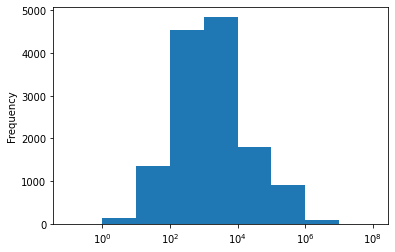

In [68]:
bins = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
df_items_multiplos_cnpjs_corrigido['vlr_global_minimo'].plot(kind='hist', bins=bins, logx=True)

In [65]:
df_items_multiplos_cnpjs_corrigido.sort_values(by='vlr_global_minimo', ascending=False)

,level_0,df_index,id_licitacao,id_item_licitacao,id_orgao,cod_orgao,nome_orgao,cod_nome_tipo_orgao,nome_tipo_orgao,nome_regiaoplanejamento,ano_exercicio,mes_licitacao,num_lote,nome_lote,num_item,nome_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_perc_taxa_adm,dsc_ind_desonera_folha,nome_licitante,cod_tipo_pessoa_licitante,cod_ibge_municipio,num_cpf_cnpj_municipio,nome_cidade,nome_microrregiao,nome_mesorregiao,nome_regiao_imediata,nome_regiao_intermediaria,sigla_uf,longitude,latitude,vlr_global_minimo,nb_of_participants
937,937,178678,688048,22550999.0,459,02,PREFEITURA MUNICIPAL DE CATAS ALTAS - MG,02,PREFEITURA MUNICIPAL,CENTRAL,2020,5,1,LOTE NUMERO: 1,1,OBRA CONST. CENTRO EDUCACIONAL,0.0,0.0,0.0,0.0,NAO,COLLEM CONSTRUTORA MOHALLEM LTDA,J,3115359,01612370000142,CATAS ALTAS,ITABIRA,METROPOLITANA DE BELO HORIZONTE,SANTA BARBARA - OURO PRETO,BELO HORIZONTE,MG,-43.4078,-20.0755,19784696.38,4
907,907,92995,681158,22360494.0,533,01,PREFEITURA MUNICIPAL DE CONGONHAS,02,PREFEITURA MUNICIPAL,CENTRAL,2020,2,NaN,NaN,1,PRESTACAO DE SERVICOS PARA PAVIMENTACAO ASFALT...,0.0,0.0,0.0,0.0,NAO,CONSTRUTORA WANTEC LTDA,J,3118007,16752446000102,CONGONHAS,CONSELHEIRO LAFAIETE,METROPOLITANA DE BELO HORIZONTE,CONSELHEIRO LAFAIETE,BARBACENA,MG,-43.8616,-20.5161,14599973.06,6
2378,2378,112032,751167,24507503.0,736,02,PREFEITURA MUNICIPAL DE EXTREMA,02,PREFEITURA MUNICIPAL,SUL,2020,5,NaN,NaN,1,"EXECUCAO DE REFORMAS, AMPLIACOES E CONSTRUCAO ...",0.0,0.0,0.0,0.0,NAO,EXTRA ENGENHARIA LTDA,J,3125101,18677591000100,EXTREMA,POUSO ALEGRE,SUL/SUDOESTE DE MINAS,POUSO ALEGRE,POUSO ALEGRE,MG,-46.2897,-22.8252,13530890.87,2
11857,11857,91445,860407,28097457.0,533,01,PREFEITURA MUNICIPAL DE CONGONHAS,02,PREFEITURA MUNICIPAL,CENTRAL,2020,4,NaN,NaN,1,SERVICO DE LIMPEZA URBANA - SERVICO,0.0,0.0,0.0,0.0,NAO,ECP ENGENHARIA LTDA,J,3118007,16752446000102,CONGONHAS,CONSELHEIRO LAFAIETE,METROPOLITANA DE BELO HORIZONTE,CONSELHEIRO LAFAIETE,BARBACENA,MG,-43.8616,-20.5161,8715913.69,5
9203,9203,143350,820414,26621116.0,1460,02,PREFEITURA MUNICIPAL DE PATROCINIO,02,PREFEITURA MUNICIPAL,ALTO PARANAIBA,2020,11,NaN,NaN,2,113869 - CONTRATACAO DE EMPRESA ESPECIALIZADA ...,0.0,0.0,0.0,0.0,NAO,CONSTRUTORA ITAMARACA LTDA,J,3148103,18468033000126,PATROCINIO,PATROCINIO,TRIANGULO MINEIRO/ALTO PARANAIBA,PATROCINIO,PATOS DE MINAS,MG,-47.0513,-18.9705,8287688.61,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10878,10878,76213,842886,27439525.0,1371,02,PREFEITURA MUNICIPAL DE OLHOS D`AGUA,02,PREFEITURA MUNICIPAL,NORTE,2021,5,NaN,NaN,5,ADAPTADOR PVC SOLDAVEL CURTO COM BOLSA E ROSCA...,0.0,0.0,0.0,0.0,NAO,TRIUNFO PRE MOLDADOS E CONSTRUTORA EIRELI,J,3145455,01612547000100,OLHOS-D'AGUA,BOCAIUVA,NORTE DE MINAS,MONTES CLAROS,MONTES CLAROS,MG,-43.5949,-17.477999999999998,0.58,3
9818,9818,100847,837338,27218244.0,1371,02,PREFEITURA MUNICIPAL DE OLHOS D`AGUA,02,PREFEITURA MUNICIPAL,NORTE,2020,10,NaN,NaN,6,ADAPTADOR PVC SOLDAVEL CURTO COM BOLSA E ROSCA...,0.0,0.0,0.0,0.0,NAO,L & J . CONSTRUCOES E TRANSPORTES LTDA,J,3145455,01612547000100,OLHOS-D'AGUA,BOCAIUVA,NORTE DE MINAS,MONTES CLAROS,MONTES CLAROS,MG,-43.5949,-17.477999999999998,0.56,3
9718,9718,100888,837338,27218144.0,1371,02,PREFEITURA MUNICIPAL DE OLHOS D`AGUA,02,PREFEITURA MUNICIPAL,NORTE,2020,10,NaN,NaN,5,ADAPTADOR PVC SOLDAVEL CURTO COM BOLSA E ROSCA...,0.0,0.0,0.0,0.0,NAO,APICE CONSTRUCOES & ENGENHARIA EIRELI,J,3145455,01612547000100,OLHOS-D'AGUA,BOCAIUVA,NORTE DE MINAS,MONTES CLAROS,MONTES CLAROS,MG,-43.5949,-17.477999999999998,0.54,3
10599,10599,167495,841793,27398929.0,713,02,PREFEITURA MUNICIPAL DE ESPERA FELIZ,02,PREFEITURA MUNICIPAL,MATA,2021,5,NaN,NaN,3,DEMOLICAO DE ALVENARIA DE TIJOLO,0.0,0.0,0.0,0.0,NAO,N S MAIA,J,3124203,18114264000131,ESPERA FELIZ,MURIAE,ZONA DA MATA,CARANGOLA,JUIZ DE FORA,MG,-41.9299,-20.5973,0.47,2


## Utilidades gerais

In [48]:
df

,id_licitacao,id_item_licitacao,num_lote,num_item,vlr_unitario,num_quant_item,vlr_perc_desconto,vlr_global,nome_cidade
0,111889,3913090,NaN,1,10710.0,1.0,0.0,0.0,IRAI DE MINAS
1,111846,3911900,NaN,1,40000.0,1.0,0.0,0.0,IRAI DE MINAS
2,111846,3911901,NaN,2,39265.0,1.0,0.0,0.0,IRAI DE MINAS
3,111852,3911940,NaN,36,21.0,25.0,0.0,0.0,IRAI DE MINAS
4,111852,3911952,NaN,49,1.4,450.0,0.0,0.0,IRAI DE MINAS
...,...,...,...,...,...,...,...,...,...
29866932,582068,19038527,NaN,1,30885.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO
29866933,582067,19038526,NaN,1,38911.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO
29866934,582068,19038527,NaN,1,32309.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO
29866935,582068,19038527,NaN,1,33790.0,1.0,0.0,0.0,SANTO ANTONIO DO AMPARO


In [55]:
filtered_df = df.drop_duplicates()
filtered_df

MemoryError: Unable to allocate 228. MiB for an array with shape (29866937,) and data type int64

In [17]:
cnpjs = df['num_cpf_cnpj_licitante']
df = df.drop(columns=['vlr_global_efetivo', 'num_cpf_cnpj_licitante'])

In [62]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [10]:
gc.collect()

0